In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import logging
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Agregar el directorio raíz del proyecto al path de Python
project_root = str(Path().absolute().parent)
if project_root not in sys.path:
    sys.path.append(project_root)

# Importar nuestros módulos
from src.data.preprocessing.text_preprocessing import TextPreprocessor
from src.models.traditional.balanced_model_training import BalancedSentimentClassifier
from src.visualization.model_evaluation import plot_confusion_matrix, plot_class_distribution, plot_model_comparison

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [14]:
# Celda 2: Cargar y preprocesar datos
data_file = "../data/processed/consolidated_reviews.csv"
df = pd.read_csv(data_file)

# Mostrar información inicial
print("Dimensiones del dataset:", df.shape)
print("\nColumnas disponibles:")
print(df.columns.tolist())
print("\nPrimeras filas:")
display(df.head())

# Inicializar preprocesador
preprocessor = TextPreprocessor()

# Preprocesar textos
logger.info("Preprocesando textos...")
df['reviews.text_processed'] = df['reviews.text'].apply(preprocessor.preprocess)

Dimensiones del dataset: (67992, 14)

Columnas disponibles:
['id', 'name', 'brand', 'categories', 'reviews.id', 'reviews.date', 'reviews.doRecommend', 'reviews.numHelpful', 'reviews.rating', 'reviews.text', 'reviews.title', 'reviews.username', 'text_length', 'sentiment']

Primeras filas:


,id,name,brand,categories,reviews.id,reviews.date,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.text,reviews.title,reviews.username,text_length,sentiment
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",NaN,2017-01-13 00:00:00+00:00,True,0.0,5.0,This product so far has not disappointed. My c...,Kindle,Adapter,143,positive
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",NaN,2017-01-13 00:00:00+00:00,True,0.0,5.0,great for beginner or experienced person. Boug...,very fast,truman,75,positive
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",NaN,2017-01-13 00:00:00+00:00,True,0.0,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,DaveZ,131,positive
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",NaN,2017-01-13 00:00:00+00:00,True,0.0,4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!,Shacks,593,positive
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",NaN,2017-01-12 00:00:00+00:00,True,0.0,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,explore42,613,positive


2025-01-23 12:10:40,122 - src.data.preprocessing.text_preprocessing - INFO - Inicializando TextPreprocessor...
2025-01-23 12:10:40,123 - src.data.preprocessing.text_preprocessing - INFO - TextPreprocessor inicializado correctamente
2025-01-23 12:10:40,123 - __main__ - INFO - Preprocesando textos...


2025-01-23 12:10:47,148 - __main__ - INFO - Datos preprocesados guardados en ../data/processed/reviews_preprocessed.csv


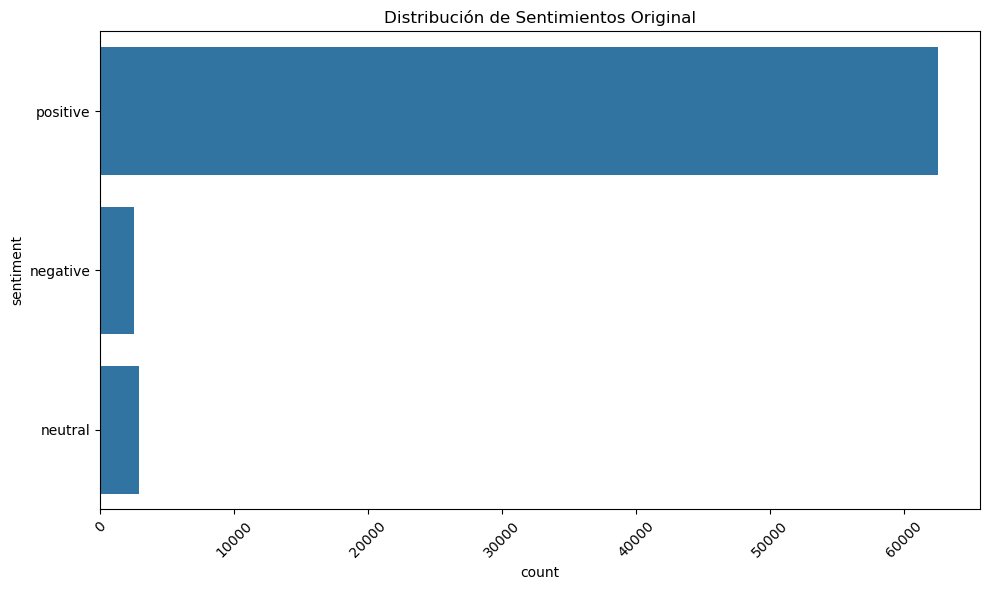

In [15]:
# Celda 3: Preparar etiquetas
if 'sentiment' not in df.columns:
    def map_ratings_to_sentiment(rating):
        if rating <= 2:
            return 'negative'
        elif rating == 3:
            return 'neutral'
        else:
            return 'positive'
    
    df['sentiment'] = df['reviews.rating'].apply(map_ratings_to_sentiment)

# Guardar DataFrame preprocesado
processed_data_file = "../data/processed/reviews_preprocessed.csv"
df.to_csv(processed_data_file, index=False)
logger.info(f"Datos preprocesados guardados en {processed_data_file}")

# Visualizar distribución de sentimientos
plot_class_distribution(df['sentiment'], "Distribución de Sentimientos Original")

2025-01-23 12:10:47,260 - src.models.traditional.balanced_model_training - INFO - Cargando y preparando datos...
2025-01-23 12:10:47,524 - src.models.traditional.balanced_model_training - INFO - Valores nulos antes de limpieza:
reviews.text_processed    26
sentiment                  0
dtype: int64
2025-01-23 12:10:47,541 - src.models.traditional.balanced_model_training - INFO - Registros después de limpieza: 67992
2025-01-23 12:10:47,542 - src.models.traditional.balanced_model_training - INFO - 
Distribución de clases original:
sentiment
positive    62547
neutral      2902
negative     2543
Name: count, dtype: int64
2025-01-23 12:10:47,566 - src.models.traditional.balanced_model_training - INFO - Datos divididos - Train: 54393, Test: 13599
2025-01-23 12:10:47,573 - src.models.traditional.balanced_model_training - INFO - 
Entrenando modelo balanceado: naive_bayes_balanced
/opt/anaconda3/envs/nlp-reviews/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._vali

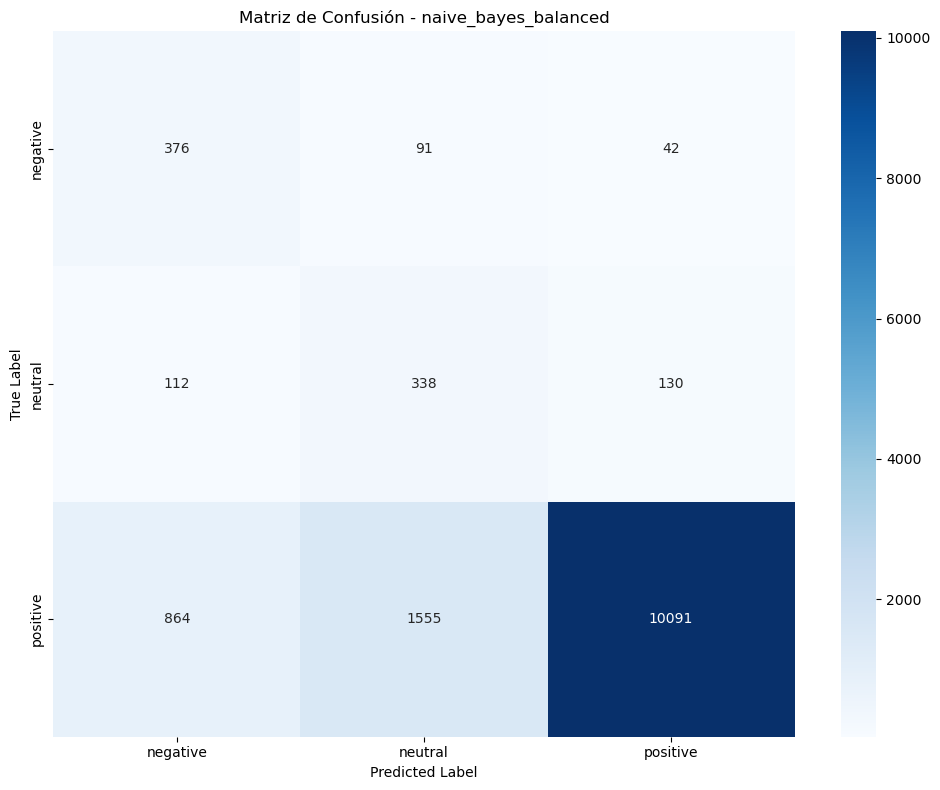

/opt/anaconda3/envs/nlp-reviews/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/nlp-reviews/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/nlp-reviews/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/nlp-reviews

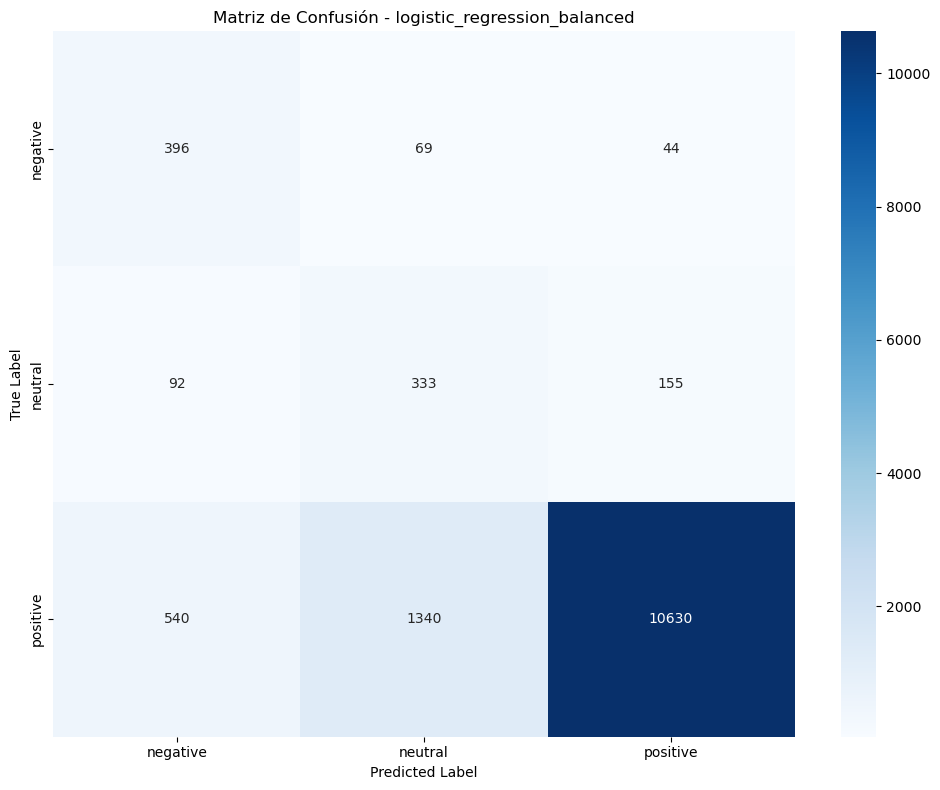

/opt/anaconda3/envs/nlp-reviews/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/nlp-reviews/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/nlp-reviews/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/nlp-reviews

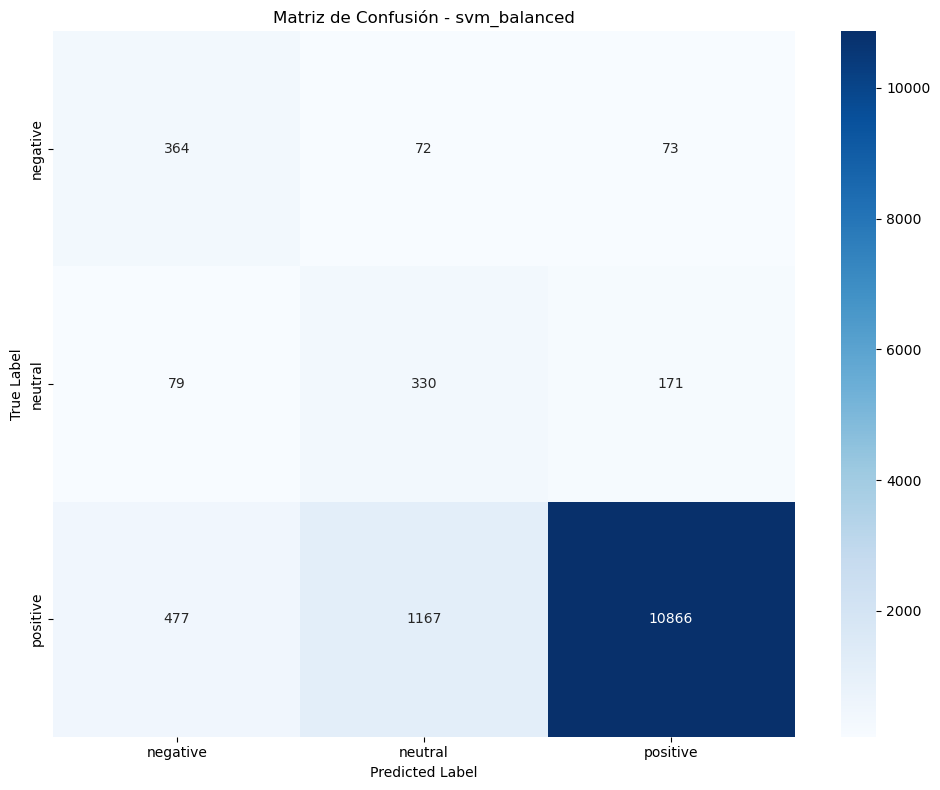

/opt/anaconda3/envs/nlp-reviews/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/nlp-reviews/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/nlp-reviews/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/nlp-reviews

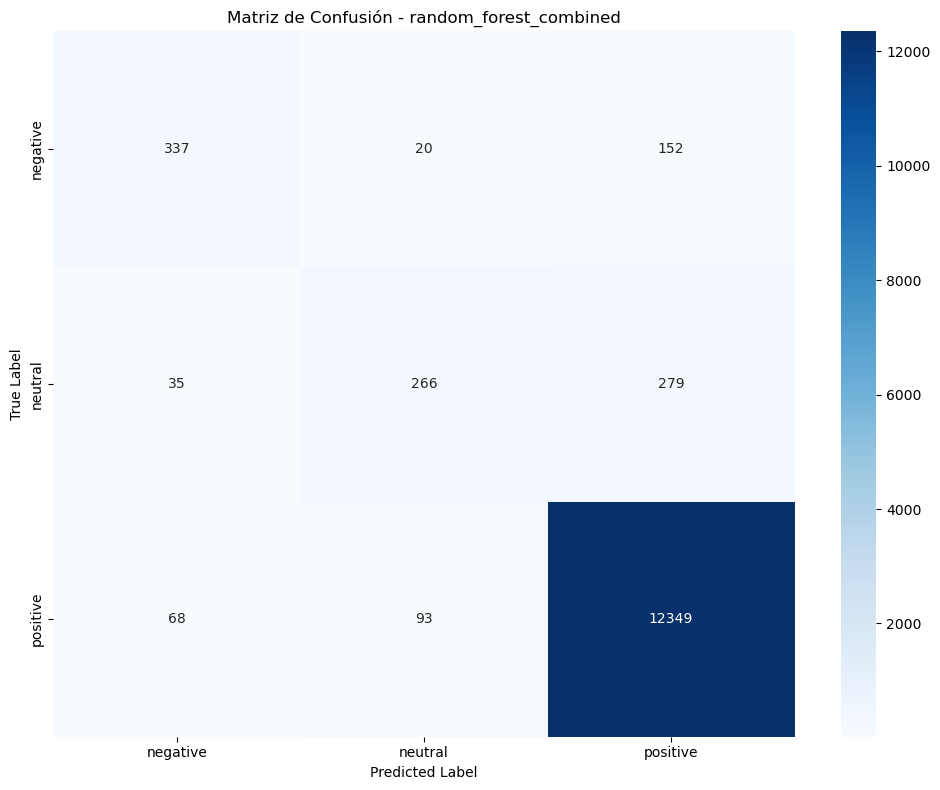

/opt/anaconda3/envs/nlp-reviews/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/nlp-reviews/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/nlp-reviews/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/nlp-reviews

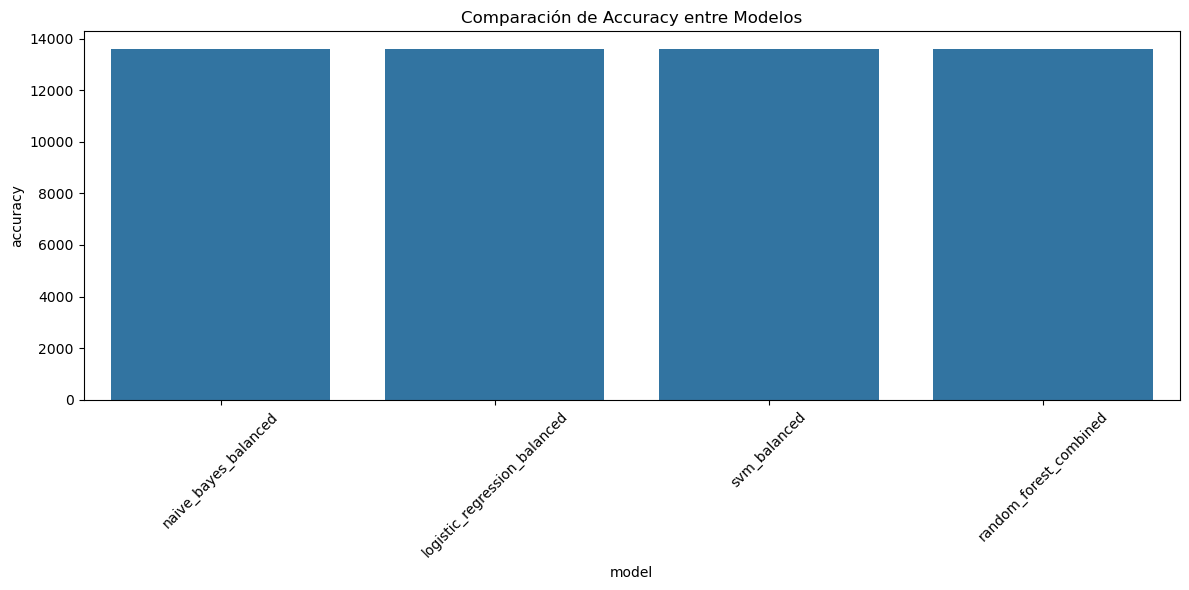

In [16]:
# Celda 4: Entrenamiento y evaluación
# Inicializar clasificador
classifier = BalancedSentimentClassifier()

# Preparar datos
X_train, X_test, y_train, y_test = classifier.prepare_data(processed_data_file)

# Entrenar y evaluar modelos
results = classifier.train_and_evaluate(X_train, X_test, y_train, y_test, "../models/balanced")

# Visualizar resultados comparativos
plot_model_comparison(results)

In [19]:
# Verificar la estructura de resultados
print("\nEstructura de resultados:")
for model_name, result in results.items():
    print(f"\nModelo: {model_name}")
    print("Claves disponibles:", list(result.keys()))
    if 'y_true' in result:
        print("Tipo de y_true:", type(result['y_true']))
        print("Forma de y_true:", result['y_true'].shape if hasattr(result['y_true'], 'shape') else len(result['y_true']))
    if 'y_pred' in result:
        print("Tipo de y_pred:", type(result['y_pred']))
        print("Forma de y_pred:", result['y_pred'].shape if hasattr(result['y_pred'], 'shape') else len(result['y_pred']))


Estructura de resultados:

Modelo: naive_bayes_balanced
Claves disponibles: ['classification_report', 'confusion_matrix']

Modelo: logistic_regression_balanced
Claves disponibles: ['classification_report', 'confusion_matrix']

Modelo: svm_balanced
Claves disponibles: ['classification_report', 'confusion_matrix']

Modelo: random_forest_combined
Claves disponibles: ['classification_report', 'confusion_matrix']


In [21]:
# Analizar errores
def analyze_errors(classifier, model_name):
    """Analiza los errores más comunes del modelo."""
    y_true = classifier.results[model_name]['y_true']
    y_pred = classifier.results[model_name]['y_pred']
    
    error_idx = np.where(y_true != y_pred)[0]
    
    print(f"\nAnálisis de errores para {model_name}:")
    print(f"Total de errores: {len(error_idx)}")
    
    errors_df = pd.DataFrame({
        'True': y_true[error_idx],
        'Predicted': y_pred[error_idx]
    })
    
    print("\nDistribución de errores:")
    error_dist = errors_df.groupby(['True', 'Predicted']).size().unstack(fill_value=0)
    display(error_dist)
    
    # Visualizar matriz de errores
    plt.figure(figsize=(10, 6))
    sns.heatmap(error_dist, annot=True, fmt='d', cmap='YlOrRd')
    plt.title(f'Distribución de Errores - {model_name}')
    plt.tight_layout()
    plt.show()

# Analizar errores para cada modelo
for model_name in classifier.models.keys():
    analyze_errors(classifier, model_name)

KeyError: 'y_true'